In [7]:
import os
import math
import torch
import torch.nn as nn
import torch.autograd as ag
import torch.optim as optim
import torchvision
import numpy as np
import time
from torchvision import models
import ASDC_loader
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#device = torch.device('cpu')

cuda


In [8]:
# Data set
# train_dataset = ASDC_loader.ASDC_Crop_Class_Dataset(dataset='train', truncate=-1, crop=(256,256))
# print(len(train_dataset.imageIDs))
# max_idx = 192555

def make_val_ranges(max_idx, num_sets, current_num, rand=None):
    end = max_idx
    cur = current_num # range of [0, n)
    if rand is None:
        seg_len = int(np.ceil(end/num_sets))
        train_range = list(range(0, (cur)*seg_len)) + list(range((cur+1)*seg_len, max_idx))
        val_range = range((cur)*seg_len, end if cur==num_sets-1 else (cur+1)*seg_len)
        return train_range, val_range
    else:
        raise NotImplementedError

In [9]:
truncate_len = 192555
truncate_len = 160000
truncate_len = 6000
train_range, val_range = make_val_ranges(truncate_len, 4, 0)
print(len(train_range))
print(len(val_range))

train_dataset = ASDC_loader.ASDC_Crop_Class_Dataset(dataset='train', ID_idxs=train_range, truncate=truncate_len, crop=(256,256))
val_dataset = ASDC_loader.ASDC_Crop_Class_Dataset(dataset='validate', ID_idxs=val_range, truncate=truncate_len, crop=(256,256))

4500
1500


In [10]:
def onehot2label(d):
    lbl = d.argmax(dim=1)
    return lbl

def eval_class_dataset(model, loader):
    model.eval()
    num_correct = 0.0
    for idx, (images, labels) in enumerate(loader):
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)
        pred_labels = onehot2label(pred)
        num_correct += torch.sum(labels==pred_labels)
#         if idx%100 == 99:
    #         print("{:d}: {:f}".format(idx, num_correct/num_total))
#              print("{:d}: {:f}".format(idx, num_correct))
    accuracy = float(num_correct)/len(loader.dataset)
    model.train()
    return accuracy

In [11]:
def save_whole_checkpoint():
    ASDC_loader.save_checkpoint(param_path, 
                                model=model, 
                                optimizer=optimizer, 
                                epoch=epoch, 
                                idx=idx, 
                                B=B, 
                                losses=losses, 
                                train_accs=train_accs,
                                val_accs=val_accs)            

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.models.vgg import VGG

class VGGNet(VGG):
    def __init__(self, model='vgg16', requires_grad=True, if_class = True, show_params=False, n_class=2):
        super().__init__(make_layers(cfg[model]), num_classes=n_class)
        self.ranges = ranges[model]
        self.if_class = if_class
        self.classifier = nn.Sequential(
            nn.Linear(512 * 8 * 8, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, n_class),
        )

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())
        
        if not if_class:  # delete redundant fully-connected layer params, can save memory
            del self.classifier
            
        #Initilize the paremeters
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        
        if not self.if_class:
            return output
        else:
            output = output["x5"].view(x.size(0), -1)
            output = self.classifier(output)
            return output
    
    
    def remove_classifier(self):
        del self.classifier
        self.if_class = False

        
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [13]:
model = VGGNet(n_class=2).to(device) 

In [14]:
N = len(train_dataset) # Training set size 
B = 16 # Minibacth size
NB = int(N/B) # Number of minibatches
T = 13 # Number of epochs
gamma = .005 # learning rate
rho = .9 # momentum

# Data loader (this provides queues and threads in a very simple way).
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=B, 
                                           shuffle=True,
                                           num_workers=8)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=B, 
                                           shuffle=True,
                                           num_workers=8)

#test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=B)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho)
print('done')

done


In [15]:
param_path = './vgg_net_test_params.pt'

if not os.path.isfile(param_path):
    ASDC_loader.save_checkpoint(param_path, model=model, optimizer=optimizer)
    print('using new model')
else:
    print('using local model')

checkpoint_dict = ASDC_loader.load_checkpoint(param_path, model=model, optimizer=optimizer)
#print(checkpoint_dict)
# if 'B' in checkpoint_dict:
#     assert B == checkpoint_dict['B'], 'current minibatch size is %d, but saved size is %d' % (B, checkpoint_dict['B'])


using local model


In [12]:
# model.train()

# last_time = time.time()
# print('start time: %f' % time.time())

# losses = [] if 'losses' not in checkpoint_dict else checkpoint_dict['losses']
# train_accs = [] if 'train_accs' not in checkpoint_dict else checkpoint_dict['train_accs']
# val_accs = [] if 'val_accs' not in checkpoint_dict else checkpoint_dict['val_accs']

# epoch = 0
# while epoch < T:
#     if 'epoch' in checkpoint_dict and epoch <= checkpoint_dict['epoch']:
#         epoch += 1
#         continue
#     running_loss = 0.0
#     epoch_time = time.time()
    
#     for idx, (images, labels) in enumerate(train_loader):


#         images = images.to(device)
#         labels = labels.to(device)

#         # Forward pass
#         outputs = model(images).float()

#         # loss
#         loss = criterion(outputs, labels)

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         # Print averaged loss per minibatch every 100 mini-batches
#         running_loss += loss.item() 
#         if idx % 100 == 99:
#             print('[%d, %5d] loss: %.3f' % 
#                   (epoch + 1, idx + 1, running_loss/100))
#             losses.append((epoch, idx, running_loss/100))
#             running_loss = 0.0 
#             if idx <= 500:
#                 print('sec per sample: {:f}'.format((time.time()-last_time)/(B*100)))#time_per_sample = (last_time-time.time())/(B*100)
#                 last_time = time.time()
    
           
# #         # Release RAM
# #         torch.cuda.empty_cache()
        
        
#     last_time = time.time()
#     print('[{:03d} {:05d}] epoch took {:02f} secs to run'.format(epoch+1, idx+1, time.time()-epoch_time))
        
#     #evaluate accuracy
#     tmp_time = time.time()
#     train_acc = eval_class_dataset(model, train_loader)
#     print('[{:03d} {:05d}] {:02f} secs to run \t training accuracy: {:04f}'.format(epoch+1, 
#                                                                                    idx+1, 
#                                                                                    time.time()-tmp_time, 
#                                                                                    train_acc))
#     train_accs.append((epoch, idx, train_acc))
        
#     tmp_time = time.time()
#     val_acc = eval_class_dataset(model, val_loader)
#     print('[{:03d} {:05d}] {:02f} secs to run \t validati accuracy: {:04f}'.format(epoch+1, 
#                                                                                    idx+1, 
#                                                                                    time.time()-tmp_time, 
#                                                                                    val_acc))
#     val_accs.append((epoch, idx, val_acc))
    
#     #done with one epoch
#     save_whole_checkpoint()           
#     print('saved at {:f}'.format(time.time()))
    
#     epoch += 1
    
# print('Finished Training')

start time: 1544736125.374135
[1,   100] loss: 0.662
sec per sample: 0.024108
[1,   200] loss: 0.654
sec per sample: 0.022519
[1,   300] loss: 0.640
sec per sample: 0.022176
[001 00345] epoch took 126.000893 secs to run
[001 00345] 60.857356 secs to run 	 training accuracy: 0.806054
[001 00345] 20.678659 secs to run 	 validati accuracy: 0.790503


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type VGGNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


saved at 1544736336.120765
[2,   100] loss: 0.441
sec per sample: 0.075574
[2,   200] loss: 0.396
sec per sample: 0.022834
[2,   300] loss: 0.381
sec per sample: 0.021755
[002 00345] epoch took 123.513956 secs to run
[002 00345] 61.098413 secs to run 	 training accuracy: 0.834149
[002 00345] 21.394652 secs to run 	 validati accuracy: 0.821788
saved at 1544736545.099060
[3,   100] loss: 0.355
sec per sample: 0.078378
[3,   200] loss: 0.246
sec per sample: 0.022155
[3,   300] loss: 0.246
sec per sample: 0.022343
[003 00345] epoch took 127.968599 secs to run
[003 00345] 62.518282 secs to run 	 training accuracy: 0.902846
[003 00345] 21.414226 secs to run 	 validati accuracy: 0.880447
saved at 1544736761.031768
[4,   100] loss: 0.212
sec per sample: 0.078676
[4,   200] loss: 0.204
sec per sample: 0.022951
[4,   300] loss: 0.204
sec per sample: 0.023185
[004 00345] epoch took 127.522919 secs to run
[004 00345] 60.816407 secs to run 	 training accuracy: 0.937285
[004 00345] 20.157012 secs to

In [ ]:
# # checkpoint_dict
# it = iter(train_loader)
# print(len(it))
# len(train_loader)
# i, l = it.next()
# print(i.shape)
# print(l.shape)

In [13]:
print(loss)
print(torch.Tensor.backward)

tensor(1.00000e-02 *
       7.9713, device='cuda:0')
<function Tensor.backward at 0x7f00cc0ec2f0>


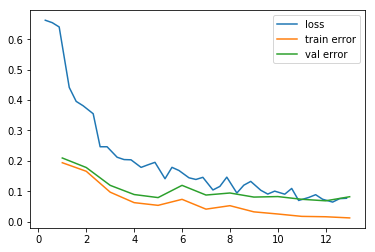

In [17]:
plt.figure()
max_idx = float(len(train_loader))
plot_losses = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['losses']])
plot_t_a = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['train_accs']])
plot_v_a = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['val_accs']])
plt.plot(plot_losses[:,0], plot_losses[:,1], label='loss')
plt.plot(plot_t_a[:,0], 1- plot_t_a[:,1], label='train error')
plt.plot(plot_v_a[:,0], 1- plot_v_a[:,1], label='val error')
legend = plt.legend(loc='upper right')
plt.savefig("error.png")

TypeError: slice indices must be integers or None or have an __index__ method

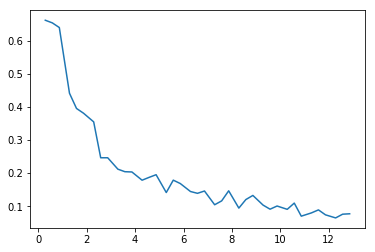

In [20]:
plt.figure()
r = (0,1)
zoom = slice(r[0],r[1])
zoom_l = slice(r[0]*180,r[1]*180)
zoom = slice(':')
max_idx = float(len(train_loader))
plot_losses = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['losses']])
plot_t_a = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['train_accs']])
plot_v_a = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['val_accs']])
plt.plot(plot_losses[zoom_l,0], plot_losses[zoom_l,1], label='loss')
plt.plot(plot_t_a[zoom,0], 1- plot_t_a[zoom,1], label='train error')
plt.plot(plot_v_a[zoom,0], 1- plot_v_a[zoom,1], label='val error')
plt.ylim(0, 0.1)
legend = plt.legend(loc='upper right')

plt.savefig("error2.png")

In [ ]:
print(len(plot_losses))
print(len(plot_t_a))

In [ ]:
plt.figure()
max_idx = float(len(train_loader))
plot_losses = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['losses']])
plot_t_a = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['train_accs']])
plot_v_a = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['val_accs']])
plt.plot(plot_losses[:,0], plot_losses[:,1], label='loss')
plt.plot(plot_t_a[:,0], 1- plot_t_a[:,1], label='train error')
plt.plot(plot_v_a[:,0], 1- plot_v_a[:,1], label='val error')
plt.ylim(0, 0.1)
legend = plt.legend(loc='upper right')

In [ ]:
raise # debug

In [ ]:
zoom*180

In [ ]:
### view images
idx2label = ASDC_loader.get_IN_labels()
idx2label[0] = 'ASDC_ship'
idx2label[1] = 'ASDC_background'

model.eval()

idxs = range(200000,200000+100,10)
print(idxs)
#idxs = [10]
for i in idxs:
    view_image, view_label = train_dataset[i]
    
    view_image = torch.unsqueeze(view_image, dim=0).to(device)
    view_label = torch.unsqueeze(torch.LongTensor([view_label]), dim=0).to(device)

    view_pred_labels = model(view_image)
    #print(labels.shape)
    title = 'pred: ' + str(view_label.item())
    
    plt.figure(i)
    plt.subplot(1,2,1)
    plt.imshow(ASDC_loader.torch2regular_image(view_image.cpu()[0,:,:,:]))
    plt.title(str(i))
    #cropped_image = ASDC_loader.crop_torch_image(image, (227,227))
    #print(cropped_image.shape)
    #plt.imshow(ASDC_loader.torch2regular_image(cropped_image[0,:,:,:]))
    #print(image.shape)
    plt.subplot(1,2,2)
    ship_mask = train_dataset.get_mask(i)
    plt.imshow(ship_mask[0,:,:])

    plt.title(title)


In [ ]:
raise

In [ ]:
type(optimizer)


In [ ]:
import math
print(loss)
#print(loss.data)
#print(loss.item()==torch.Tensor([float('nan')]).item())
print(math.isnan(loss.item()))
#print(type(torch.Tensor([float('nan')]).item()))

#print(float('nan')==float('nan'))


In [ ]:
print(labels.shape)
print(outputs.grad)

In [ ]:
print(str(model))
print(str(optimizer))

In [ ]:
print([key for key in checkpoint_dict])
print([ '{:s}: {:s}'.format(key, str(checkpoint_dict[key])) for key in ['model_type', 'optimizer_type', 'epoch', 'idx', 'B', 'losses', 'train_accs', 'val_accs'] ])
#print(checkpoint_dict['idx'])

In [ ]:
#val_dataset
# a = iter(val_loader)
# a = val_loader.__iter__()

# val_accuracy = eval_class_dataset(model, val_loader)
# train_accuracy = eval_class_dataset(model, train_loader)
print(val_accuracy)
print(train_accuracy)

In [ ]:
def check_checkpoint_file(path, max_len=30):
    checkpoint_dict = ASDC_loader.load_checkpoint(path)
    for key in checkpoint_dict:
        val_str = str(checkpoint_dict[key])
        print('{:s}: {:s}'.format(key, val_str[:max_len]))

# check_checkpoint_file('alex_net_test_params.pt.back')

print('-----------------')

check_checkpoint_file('alex_net_test_params.pt')